# Studying Stock Returns vs Social Sentiments

Are stock returns and social sentiments related? What is the relationship if we expect one?

And more importantly, could we use social sentiments to predict stock returns?

In this study, we will quickly look at **Social Sentiments** on **Tweets** using the `TextBlob` and `ntlk.vadar` package. And we will compare daily sentiments with daily stock returns.

The **Stock returns** in question actually would be the [**Alpha**](https://corporatefinanceinstitute.com/resources/knowledge/finance/alpha/) of the stock, where

$$ \alpha = {R}-{Rf}- \beta ({Rm} - {Rf}) $$

for our purpose, we are going to assume that ${Rf}$ is 0

### Preliminary
For this study, we will use `alpha_vantage` to get historical returns

In [75]:
import pandas as pd
import numpy as np
from functools import reduce

# pandas data reader
import pandas_datareader.data as web
from datetime import datetime as dt

# Alpha Vantage requirements
av_api_key = 'TGXS2LEUKMHXTKT5'
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries( key = av_api_key, output_format = 'pandas')

# plotting
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
# Required for Plot.ly Offline
init_notebook_mode(connected=True)
# Cufflinks bind plotly to pandas dataframe in IPython Notebooks
cf.set_config_file(offline = False, world_readable = True, theme = 'ggplot')

## Getting Stock Returns
for our study, we are interested in the [**FANG** stocks](https://www.investopedia.com/terms/f/fang-stocks-fb-amzn.asp): `FB`, `AMZN`, `NFLX`, [`GOOG`](https://investorplace.com/2019/01/goog-google-stock-split/)

The [relevant benchmark would then be NASDAQ](https://www.forbes.com/sites/jaysomaney/2016/12/30/comparing-facebook-amazon-netflix-and-google-aka-fang-performance-in-2016/#57a2bf8952f9), which we'll use `QQQ` as proxy for.

We'll also get `SPY` just to test our calculated **Beta** vs Yahoo! Finance. The calcuation is reference from [here](https://medium.com/python-data/capm-analysis-calculating-stock-beta-as-a-regression-in-python-c82d189db536)

In [18]:
l_symbols = ['FB','AMZN', 'NFLX', 'GOOG', 'QQQ', 'SPY']
sdate = dt(2018,1,1)
edate = dt(2019,1,23)
yhoo_data = web.DataReader( l_symbols, 'yahoo', sdate, edate)

In [6]:
yhoo_data.head()

Attributes         High                                                   \
Symbols            AMZN          FB         GOOG        NFLX         QQQ   
Date                                                                       
2018-01-02  1190.000000  181.580002  1066.939941  201.649994  158.529999   
2018-01-03  1205.489990  184.779999  1086.290039  206.210007  160.169998   
2018-01-04  1215.869995  186.210007  1093.569946  207.050003  160.789993   
2018-01-05  1229.140015  186.899994  1104.250000  210.020004  162.029999   
2018-01-08  1253.079956  188.899994  1111.270020  212.500000  162.630005   

Attributes          Low                                                   \
Symbols            AMZN          FB         GOOG        NFLX         QQQ   
Date                                                                       
2018-01-02  1170.510010  177.550003  1045.229980  195.419998  156.169998   
2018-01-03  1188.300049  181.330002  1063.209961  201.500000  158.610001   
2018-01-04  1204.660034  184.100006  1084.001953  204.000000  160.080002   
2018-01-05  1210.000000  184.929993  1092.000000  205.589996  160.770004   
2018-01-08  1232.030029  186.330002  1101.619995  208.440002  161.860001   

Attributes     ...         Volume                                     \
Symbols        ...           AMZN          FB       GOOG        NFLX   
Date           ...                                                     
2018-01-02     ...      2694500.0  18151900.0  1237600.0  10966900.0   
2018-01-03     ...      3108800.0  16886600.0  1430200.0   8591400.0   
2018-01-04     ...      3022100.0  13880900.0  1004600.0   6029600.0   
2018-01-05     ...      3544700.0  13574500.0  1279100.0   7033200.0   
2018-01-08     ...      4279500.0  17994700.0  1047600.0   5580200.0   

Attributes                Adj Close                                       \
Symbols            QQQ         AMZN          FB         GOOG        NFLX   
Date                                                                       
2018-01-02  32573300.0  1189.010010  181.419998  1065.000000  201.070007   
2018-01-03  29383600.0  1204.199951  184.669998  1082.479980  205.050003   
2018-01-04  24776100.0  1209.589966  184.330002  1086.400024  205.630005   
2018-01-05  26992300.0  1229.140015  186.850006  1102.229980  209.990005   
2018-01-08  23159100.0  1246.869995  188.279999  1106.939941  212.050003   

Attributes              
Symbols            QQQ  
Date                    
2018-01-02  157.162064  
2018-01-03  158.689163  
2018-01-04  158.966827  
2018-01-05  160.563324  
2018-01-08  161.188049  

[5 rows x 30 columns]

In [19]:
data = yhoo_data.stack()
data.reset_index(inplace = True)

l_col_to_keep = ['Date', 'Symbols', 'Adj Close', 'Volume']
r_dfs = []

# 1
for sym in l_symbols:
    r_df = data[ data.Symbols == sym ].loc[:, l_col_to_keep]
    r_df = r_df.set_index('Date')
    r_df[f'r({sym})'] = r_df['Adj Close']/ r_df['Adj Close'].shift(1) - 1
    # or just do df.pct_change()
    r_dfs.append( r_df.iloc[1:,:])

# 2
df = reduce( lambda x, y : pd.concat([x,y], axis =1),
            [ r_df.iloc[:,-1] for r_df in r_dfs ]
           )

df.sort_values(by = 'Date',ascending = False).head(3)

,r(FB),r(AMZN),r(NFLX),r(GOOG),r(QQQ),r(SPY)
Date,,,,,,
2019-01-23,-0.022159,0.004810,-0.009749,0.004717,0.001297,0.002092
2019-01-22,-0.016462,-0.037749,-0.041109,-0.025258,-0.020030,-0.013510
2019-01-18,0.011733,0.001760,-0.039894,0.007670,0.009900,0.013310


In [22]:
from scipy import stats
def GetBeta( r_sym , r_benchmark):
    slope, intercept, r_value, p_value, std_err = stats.linregress( r_sym, r_benchmark)
    return slope

def GetAlpha( r_sym , r_benchmark):
    beta = GetBeta( r_sym, r_benchmark)
    return r_sym - beta * r_benchmark

In [21]:
GetBeta( df['r(FB)'], df['r(QQQ)'])

0.4091781041940176

In [45]:
alpha_fb = GetAlpha( df['r(FB)'], df['r(QQQ)'])
alpha_fb.sort_index(ascending= False).head()

Date
2019-01-23   -0.022690
2019-01-22   -0.008266
2019-01-18    0.007682
2019-01-17    0.001925
2019-01-16   -0.009391
dtype: float64

### Visualizing **Alpha**, **${Rm}$**, **${R}$**

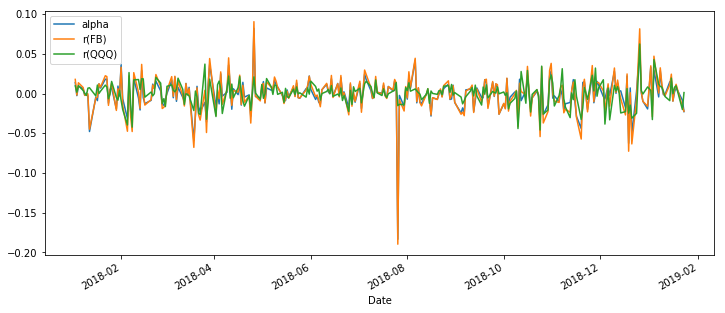

In [57]:
cols = ['alpha','r(FB)', 'r(QQQ)']
l_series = [alpha_fb, df['r(FB)'], df['r(QQQ)']]
plot_df = pd.concat( l_series, axis = 1)
plot_df.columns = cols
#plot_df = pd.DataFrame(data = l_series, columns = cols, index = alpha_fb.index)
plot_df.plot(figsize = (12,5))

In [83]:
plotly_data = [go.Scatter(x = plot_df.index, y = plot_df['alpha'], name = 'alpha'), 
               go.Scatter(x = plot_df.index, y = plot_df['r(FB)'], name = 'r(FB)'),
               go.Scatter(x = plot_df.index, y = plot_df['r(QQQ)'],name = 'r(QQQ)')
              ]
iplot(plotly_data)